In [1]:
from contextlib import ExitStack

In [2]:
import networkx as nx
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import numpy as np

In [3]:
from biological_fuzzy_logic_networks.utils import read_sif
from biological_fuzzy_logic_networks.biofuzznet import BioFuzzNet

In [4]:
es = ExitStack()
es.enter_context(torch.no_grad())

In [5]:
nodes, edges = read_sif("../network/synth/LiverDREAM_PKN.sif")

In [6]:
bfn = BioFuzzNet(nodes=nodes, edges=edges)

In [7]:
bfn.nodes['mek12']

{'node_type': 'biological', 'output_state': None, 'ground_truth': None}

In [8]:
colors = []
for node in bfn:
    if bfn.nodes[node]['node_type'] != 'biological':
        colors.append('gray')
    elif len(list(bfn.successors(node))) == 0:
        colors.append('green')
    elif len(list(bfn.predecessors(node))) == 0:
        colors.append('red')
    else:
        colors.append('blue')

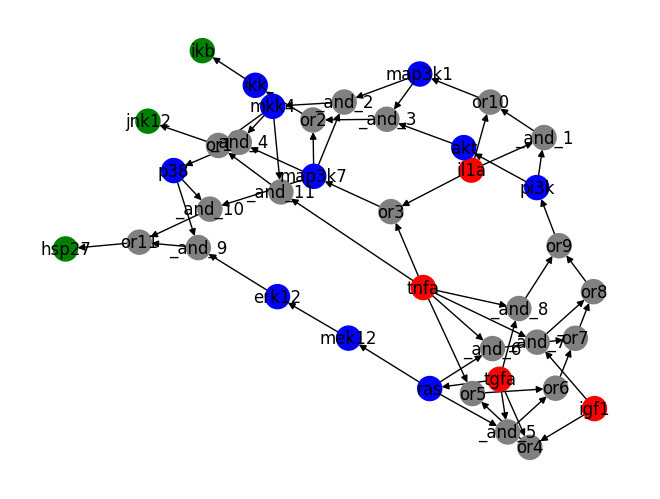

In [9]:
ps = nx.kamada_kawai_layout(bfn)
nx.draw(bfn,ps,with_labels = True,node_color=colors)

In [20]:
batch_size = 5000

df = pd.DataFrame()
df.attrs['input_nodes'] = bfn.root_nodes
df.attrs['leaf_nodes'] = [n for n in bfn.biological_nodes if len(list(bfn.successors(n))) == 0]

for n in range(1):
    batch_input = dict((k, torch.rand(batch_size)) for k in bfn.root_nodes)
    bfn.initialise_random_truth_and_output(batch_size)
    bfn.set_network_ground_truth(batch_input)
    bfn.sequential_update(bfn.root_nodes)    
    batch_dict = {}
    for node in bfn.biological_nodes:
        values = bfn.nodes[node]['output_state'].numpy()
        values += stats.norm.rvs(loc=0, scale=0.05*values)
        
        batch_dict[node] = values
    batch_df = pd.DataFrame(batch_dict)
    df = pd.concat([df,batch_df], ignore_index=True)


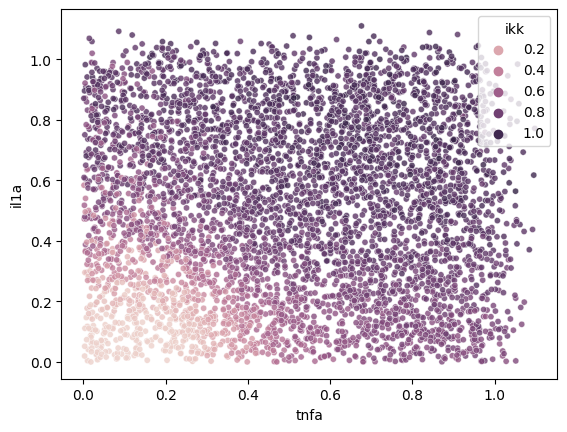

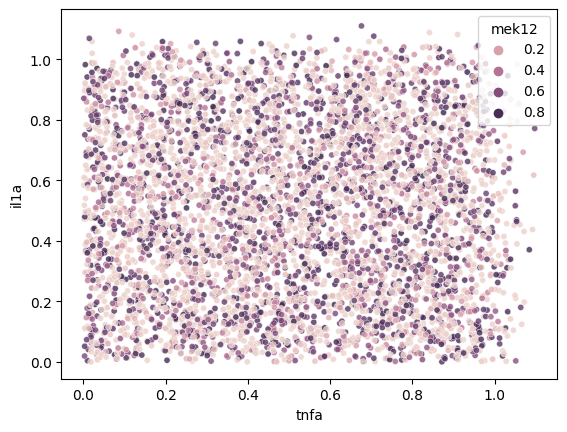

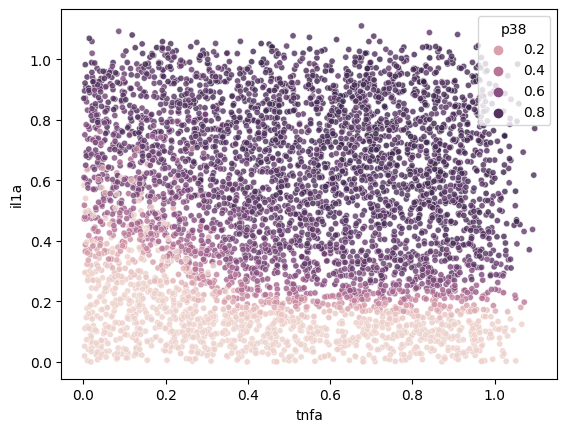

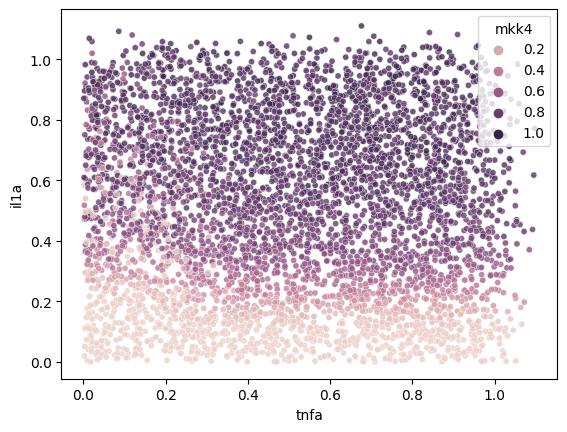

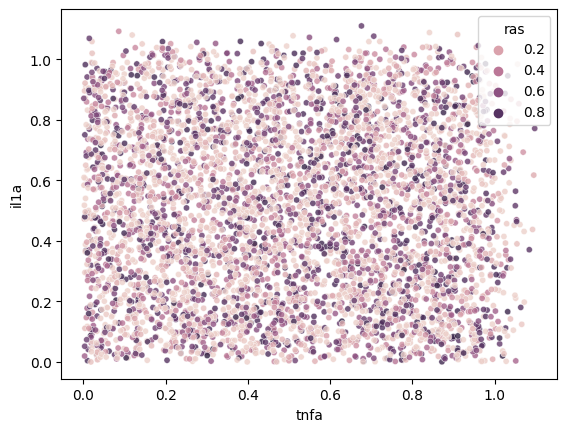

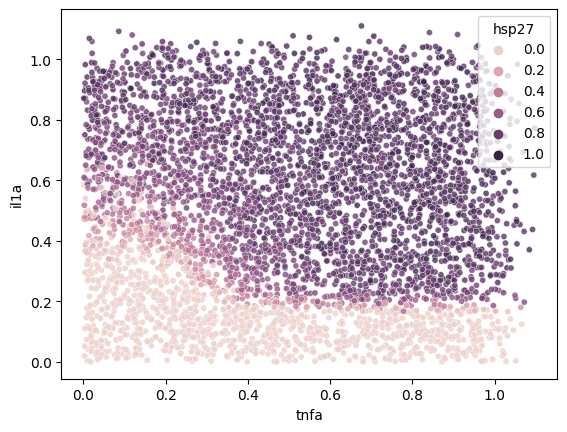

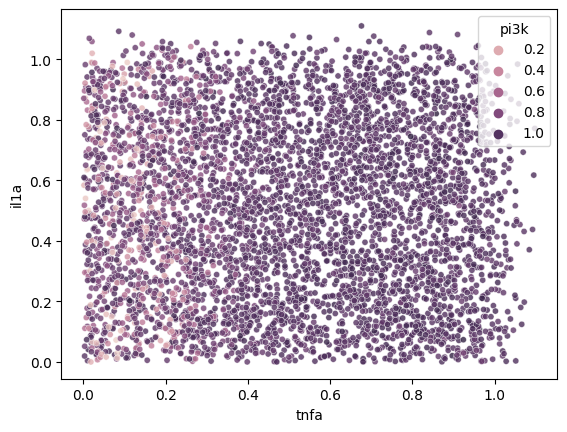

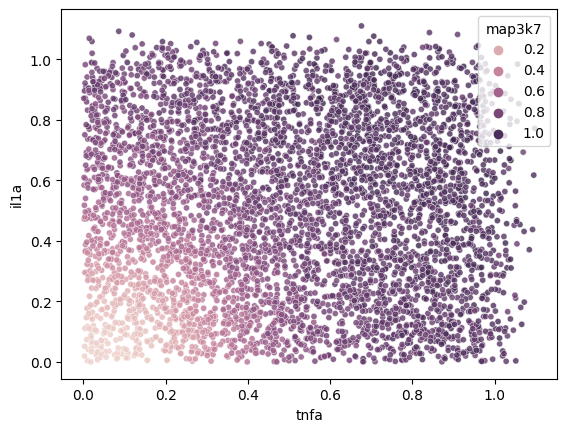

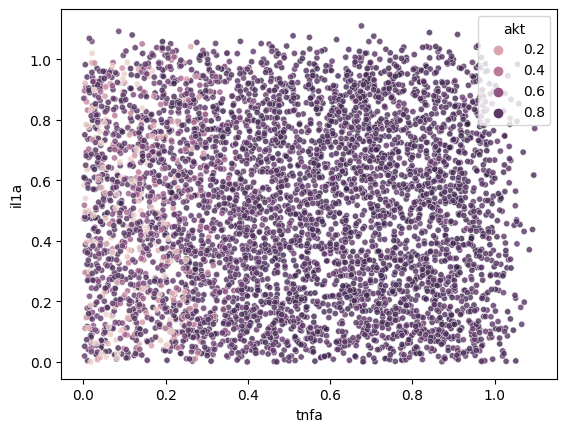

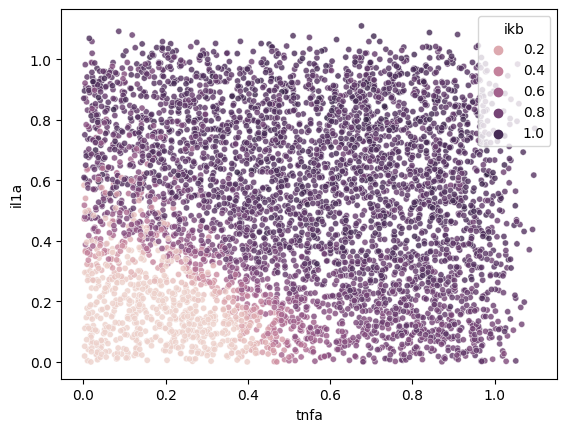

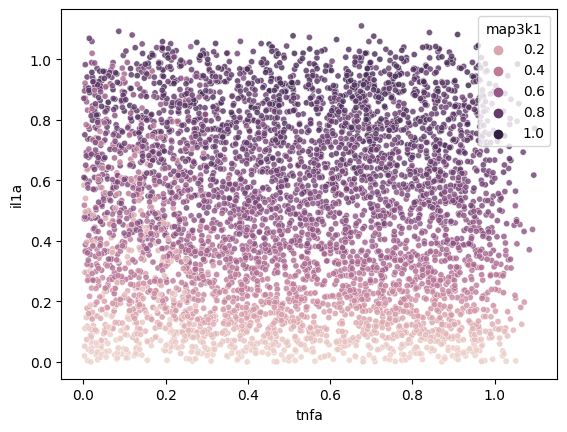

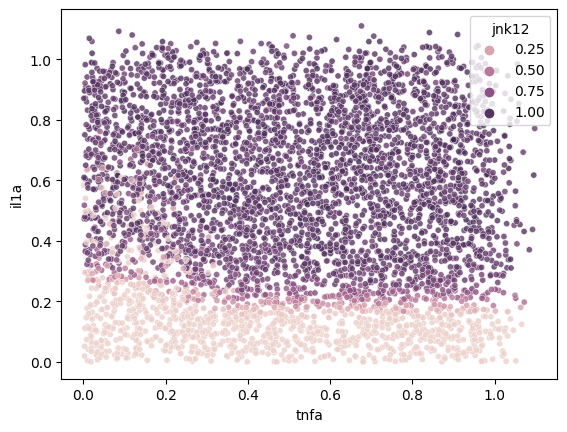

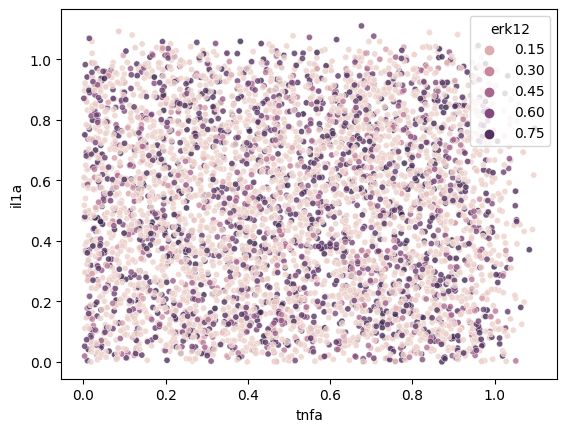

In [29]:
for node in set(bfn.biological_nodes) - set(bfn.root_nodes):
    sns.scatterplot(df,x='tnfa',y='il1a',hue=node,s=20,alpha=0.8)
    plt.show()

In [30]:
df.to_csv("../network/synth/LiverDREAM_PKN_teacher_values.csv")